<a href="https://www.kaggle.com/code/adelinmil/starter-eda-of-sleep-events?scriptVersionId=142587235" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
sleep_events = pd.read_csv('/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv',
                          dtype = {'night': object})

In [3]:
sleep_events.head()

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


In [4]:
sleep_events.describe(include = ['O'])

,series_id,night,event,timestamp
count,14510,14510,14510,9587
unique,277,84,2,9362
top,78569a801a38,2,onset,2017-11-27T21:37:00-0500
freq,168,554,7256,3


In [5]:
sleep_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14510 entries, 0 to 14509
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  14510 non-null  object 
 1   night      14510 non-null  object 
 2   event      14510 non-null  object 
 3   step       9587 non-null   float64
 4   timestamp  9587 non-null   object 
dtypes: float64(1), object(4)
memory usage: 566.9+ KB


In [6]:
pd.DataFrame({'# of null values': sleep_events.isna().sum(), '% of null values': sleep_events.isna().sum() / len(sleep_events)})\
.style.background_gradient(subset = ['% of null values'])

,# of null values,% of null values
series_id,0,0.000000
night,0,0.000000
event,0,0.000000
step,4923,0.340000
timestamp,4923,0.340000


In [7]:
sleep_events.dropna(inplace = True)

sleep_events.isna().sum()

series_id    0
night        0
event        0
step         0
timestamp    0
dtype: int64

In [8]:
sleep_events.reset_index(drop = True, inplace = True)

In [9]:
sleep_events.night.value_counts()[(sleep_events.night.value_counts() % 2 != 0)]

night
3     431
7     417
10    397
11    393
20    331
17    331
30     75
Name: count, dtype: int64

In [10]:
# Example for  logic1
sleep_events[sleep_events['night'] == '3'].groupby('series_id').get_group('655f19eabf1e')

,series_id,night,event,step,timestamp
3815,655f19eabf1e,3,onset,43104.0,2017-11-12T01:07:00-0400
3816,655f19eabf1e,3,onset,43824.0,2017-11-12T01:07:00-0500
3817,655f19eabf1e,3,wakeup,48420.0,2017-11-12T07:30:00-0500


In [11]:
# Example for logic2
sleep_events[sleep_events['night'] == '20'].groupby('series_id').get_group('0ce74d6d2106')

,series_id,night,event,step,timestamp
310,0ce74d6d2106,20,onset,332376.0,2017-09-09T22:08:00-0400


In [12]:
fault_indecies = []

for idx in range(0, len(sleep_events) - 1):
    
    logic1 = (sleep_events.loc[idx, 'event'] == sleep_events.loc[idx + 1, 'event'])\
            and (sleep_events.loc[idx, 'night'] == sleep_events.loc[idx + 1, 'night']) 
    
    logic2 = (sleep_events.loc[idx, 'night'] != sleep_events.loc[idx + 1, 'night'])\
            and (sleep_events.loc[idx, 'night'] != sleep_events.loc[idx - 1, 'night'])
    
    if logic1 or logic2:
        fault_indecies.append(idx)
    
fault_indecies  # NOTE: after dropping na  the index is reset

[310, 957, 2668, 3815, 5080, 6889, 7010, 9101, 9354]

In [13]:
sleep_events.drop(fault_indecies, axis = 0, inplace = True)

In [14]:
series = sleep_events.groupby('series_id')
series.ngroups

269

In [15]:
sleep_events.head()

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


In [16]:
ts = pd.read_parquet('/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet')

ts.head()

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.6368,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.6368,0.0215


In [17]:
# first series
group = ts[ts['series_id'] == '038441c925bb']
event = sleep_events[sleep_events['series_id'] == '038441c925bb']

In [18]:
del ts

In [19]:
group['timestamp'] = pd.to_datetime(group['timestamp'], utc = True)
event['timestamp'] = pd.to_datetime(event['timestamp'], utc = True)

In [20]:
combined = pd.merge(group, event, on=['series_id', 'timestamp'], how = 'outer')

In [21]:
combined['event'] = combined['event'].map({np.nan: 0, 'onset': -1, 'wakeup': 1})
combined.rename(columns = {'step_x': 'step'}, inplace = True)
combined.drop('step_y', axis = 1, inplace = True)

In [22]:
combined.head()

,series_id,step,timestamp,anglez,enmo,night,event
0,038441c925bb,0,2018-08-14 19:30:00+00:00,2.6367,0.0217,NaN,0
1,038441c925bb,1,2018-08-14 19:30:05+00:00,2.6368,0.0215,NaN,0
2,038441c925bb,2,2018-08-14 19:30:10+00:00,2.6370,0.0216,NaN,0
3,038441c925bb,3,2018-08-14 19:30:15+00:00,2.6368,0.0213,NaN,0
4,038441c925bb,4,2018-08-14 19:30:20+00:00,2.6368,0.0215,NaN,0


In [23]:
prev_idx = 0
for index in combined[combined.event == 1].index:
    combined.night.iloc[prev_idx: index + 5000] = combined.night.iloc[index]
    prev_idx = index + 5000
    
combined.fillna(combined.night.iloc[index], inplace = True)

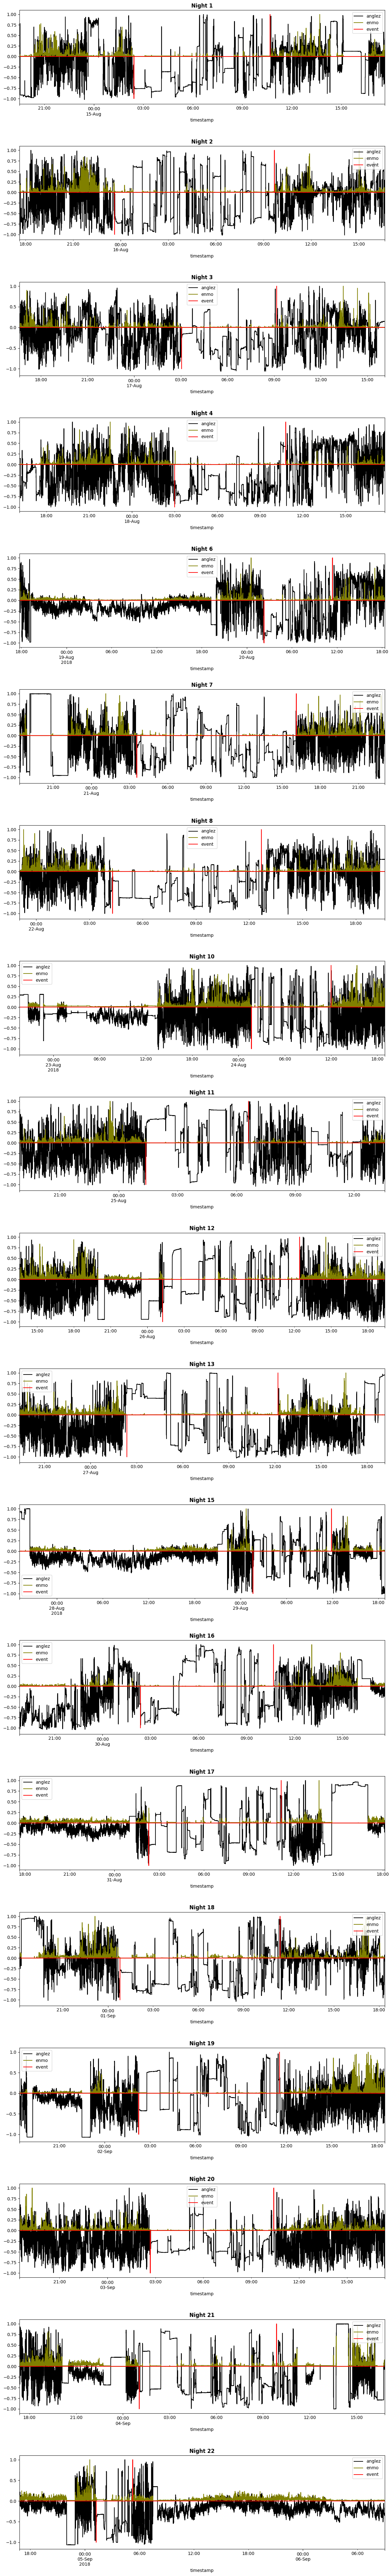

In [24]:
nights = event.night.unique()

f, axs = plt.subplots(nrows=len(nights), ncols=1)
f.set_figheight(105)
f.set_figwidth(15)

plt.subplots_adjust(
    hspace = 0.45
)

for idx, ax in enumerate(axs.ravel()):
    
    night = combined[combined.night == nights[idx]].set_index('timestamp')
    ax.set_title(f'Night {nights[idx]}', fontsize=12, weight = 'bold')
    
    (night.anglez / max(night.anglez)).plot(color = 'black', ax = ax) # noramlized
    (night.enmo / max(night.enmo)).plot(color = '#808000', ax = ax) # normalized
    night.event.plot(color = 'red', ax = ax)
    
    
    ax.legend()